# Intense Augmentation: Full-Face 

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from collections import Counter


train_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/train'
train_csv = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/train/_classes.csv'
val_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/valid'
val_csv = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/valid/_classes.csv'
test_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/test1'
test_csv = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/test1/_classes.csv'
new_test_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/testinginnewdataset'
new_test_csv = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/testinginnewdataset/_classes.csv'


img_size = (224, 224)  


def load_and_preprocess_data(data_dir, csv_path, img_size):
    """
    Load, resize, rescale images, and calculate class distribution from a directory and a CSV file.

    Args:
        data_dir (str): Path to the directory containing images.
        csv_path (str): Path to the CSV file containing filenames and labels.
        img_size (tuple): Target size for resizing images (width, height).

    Returns:
        data (np.array): Array of resized and rescaled images.
        labels (np.array): Array of corresponding labels.
        class_counts (dict): Dictionary with the number of images in each class.
    """
    
    df = pd.read_csv(csv_path)
    
    
    img_path_column = 'filename'  
    label_column = ' drowsy'     
    
    data = []
    labels = []
    for idx, row in df.iterrows():
        
        img_path = os.path.join(data_dir, row[img_path_column])
        
        
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}. Skipping.")
            continue
        
        
        img = cv2.resize(img, img_size)
        
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        img = img.astype('float32') / 255.0
        
        
        data.append(img)
        labels.append(row[label_column])  
    
    
    class_counts = dict(Counter(labels))
    
    
    return np.array(data), np.array(labels), class_counts


train_data, train_labels, train_class_counts = load_and_preprocess_data(train_dir, train_csv, img_size)
val_data, val_labels, val_class_counts = load_and_preprocess_data(val_dir, val_csv, img_size)
test_data, test_labels, test_class_counts = load_and_preprocess_data(test_dir, test_csv, img_size)
new_test_data, new_test_labels, new_test_class_counts = load_and_preprocess_data(new_test_dir, new_test_csv, img_size)


print(f"Training Set: {len(train_data)} images")
print(f"Validation Set: {len(val_data)} images")
print(f"Test Set 1: {len(test_data)} images")
print(f"Test Set 2 (New Test): {len(new_test_data)} images")


print("\nClass distribution in training set:", train_class_counts)
print("Class distribution in validation set:", val_class_counts)
print("Class distribution in test set 1:", test_class_counts)
print("Class distribution in test set 2 (New Test):", new_test_class_counts)


Training Set: 3068 images
Validation Set: 246 images
Test Set 1: 168 images
Test Set 2 (New Test): 409 images

Class distribution in training set: {0: 1531, 1: 1537}
Class distribution in validation set: {1: 123, 0: 123}
Class distribution in test set 1: {1: 70, 0: 98}
Class distribution in test set 2 (New Test): {0: 195, 1: 214}


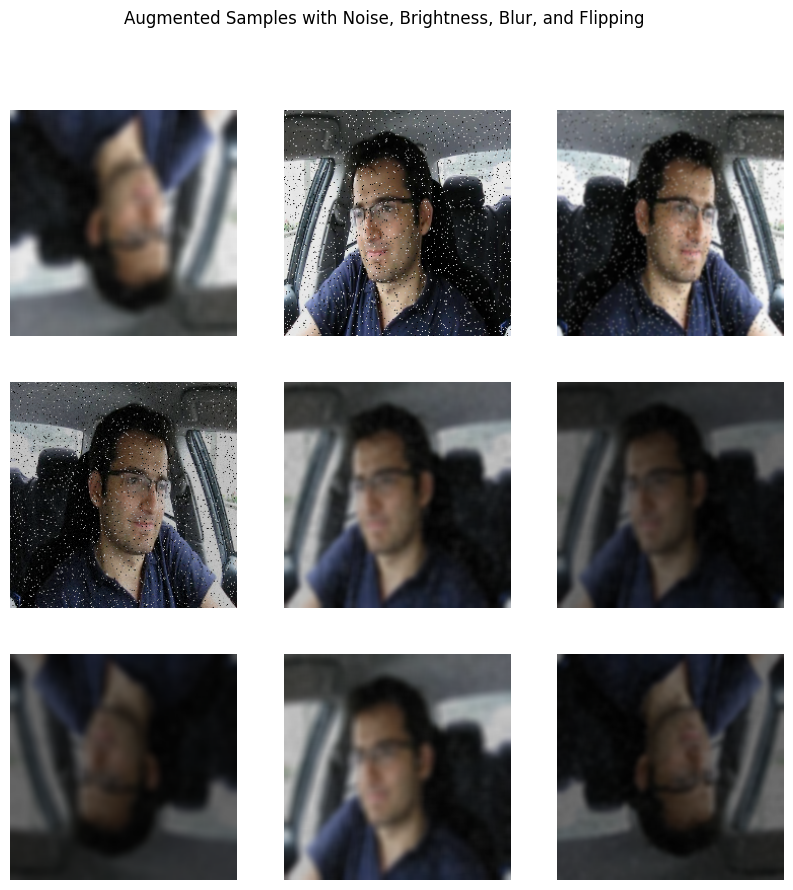

In [2]:
import numpy as np
import imgaug.augmenters as iaa
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

class ImgAugDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, augmenter=None, shuffle=True, **kwargs):
        """
        Custom data generator for augmenting and batching images.

        Args:
            images (np.array): Array of preprocessed input images.
            labels (np.array): Array of corresponding labels.
            batch_size (int): Number of images per batch.
            augmenter (imgaug.augmenters.Sequential): Augmentation pipeline.
            shuffle (bool): Whether to shuffle the data at the end of each epoch.
        """
        super().__init__(**kwargs)  
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.augmenter = augmenter
        self.shuffle = shuffle
        self.indices = np.arange(len(self.images))
        self.on_epoch_end()  

    def __len__(self):
        
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.

        Args:
            index (int): Batch index.

        Returns:
            tuple: Batch of images and corresponding labels.
        """
        
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_labels = self.labels[batch_indices]

        
        batch_images_uint8 = (batch_images * 255).astype('uint8')  

        
        if self.augmenter:
            batch_images_uint8 = self.augmenter(images=batch_images_uint8)

        
        batch_images = batch_images_uint8.astype('float32') / 255.0

        return batch_images, batch_labels

    def on_epoch_end(self):
        """
        Shuffle data indices at the end of each epoch if `shuffle` is True.
        """
        if self.shuffle:
            np.random.shuffle(self.indices)



augmenter = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  
    iaa.SaltAndPepper(0.06),                           
    iaa.Multiply((0.3, 1.0)),                          
    iaa.GaussianBlur(sigma=(0.0, 5.0)),                
    iaa.Fliplr(0.5),                                   
    iaa.Flipud(0.3)                                    
])


batch_size = 16


train_gen = ImgAugDataGenerator(train_data, train_labels, batch_size, augmenter, shuffle=True)
val_gen = ImgAugDataGenerator(val_data, val_labels, batch_size, augmenter=None, shuffle=False)
test_gen = ImgAugDataGenerator(test_data, test_labels, batch_size, augmenter=None, shuffle=False)
new_test_gen = ImgAugDataGenerator(new_test_data, new_test_labels, batch_size, augmenter=None, shuffle=False)


try:
    
    sample_image = train_data[0]  
    if len(sample_image.shape) == 3:  
        sample_image = np.expand_dims(sample_image, axis=0)  

    
    batch_sample_images = np.repeat(sample_image, 9, axis=0)  

    
    batch_sample_images_uint8 = (batch_sample_images * 255).astype('uint8')  

    
    augmented_images = augmenter(images=batch_sample_images_uint8)

    
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i])  
        plt.axis('off')
    plt.suptitle("Augmented Samples with Noise, Brightness, Blur, and Flipping")
    plt.show()

except Exception as e:
    print(f"Error during augmentation or visualization: {e}")



### MobileNetV3Small

In [3]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')  
for layer in base_model.layers[:60]:  
    layer.trainable = False
inputs = Input(shape=(224, 224, 3), name='image_input')  
x = base_model(inputs)  
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  

mobilenet_model = Model(inputs, output)

mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

history = mobilenet_model.fit(
    train_gen,  
    validation_data=val_gen,  
    epochs=15,
    callbacks=[early_stopping],  
    batch_size=32
)


Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 87s 340ms/step - accuracy: 0.5279 - loss: 1.9974 - val_accuracy: 0.5042 - val_loss: 0.9289
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 61s 320ms/step - accuracy: 0.6168 - loss: 0.7905 - val_accuracy: 0.5042 - val_loss: 0.7626
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 71s 368ms/step - accuracy: 0.6500 - loss: 0.6307 - val_accuracy: 0.5042 - val_loss: 1.1323
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 74s 389ms/step - accuracy: 0.6498 - loss: 0.5984 - val_accuracy: 0.5833 - val_loss: 0.6603
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 429ms/step - accuracy: 0.6828 - loss: 0.5771 - val_accuracy: 0.5333 - val_loss: 0.7338
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 72s 377ms/step - accuracy: 0.7020 - loss: 0.5587 - val_accuracy: 0.6125 - val_loss: 0.6539
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 69s 362ms/step - accuracy: 0.7161 - loss: 0.5233 - val_accuracy: 0.4458 - val_loss: 3.8298
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 67s 352ms/step - accuracy: 0.7453 - loss: 0

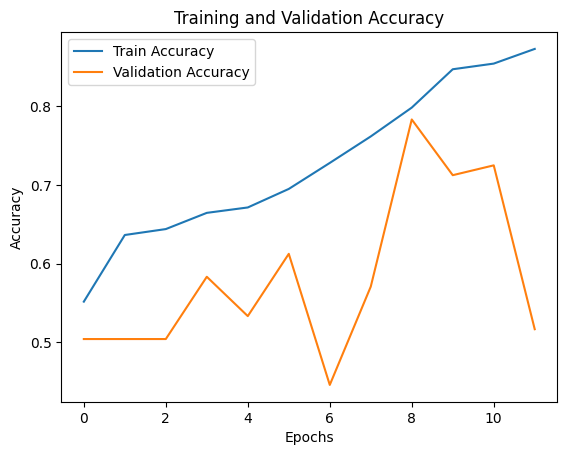

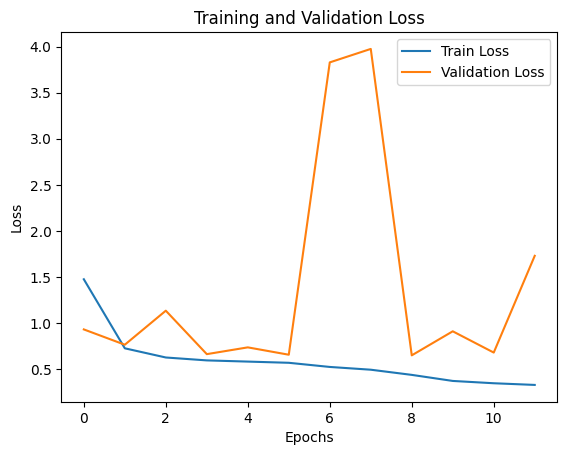

In [4]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [16]:

final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]
final_training_loss = history.history['loss'][-1]
final_validation_loss = history.history['val_loss'][-1]

print("Final Training Accuracy: {:.4f}".format(final_training_accuracy))
print("Final Validation Accuracy: {:.4f}".format(final_validation_accuracy))
print("Final Training Loss: {:.4f}".format(final_training_loss))
print("Final Validation Loss: {:.4f}".format(final_validation_loss))

Final Training Accuracy: 0.8730
Final Validation Accuracy: 0.5167
Final Training Loss: 0.3258
Final Validation Loss: 1.7284


Evaluation on Test Set 1:
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step
Test Set 1 - Accuracy: 0.5938

Test Set 1 - Confusion Matrix:


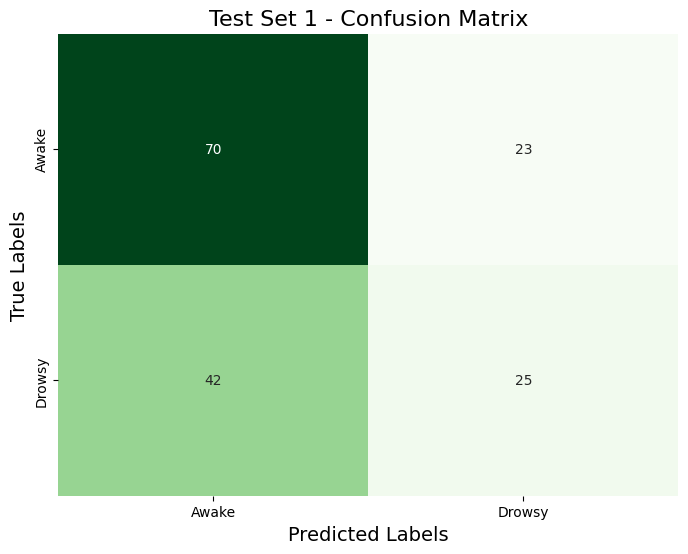

Test Set 1 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.62      0.75      0.68        93
      Drowsy       0.52      0.37      0.43        67

    accuracy                           0.59       160
   macro avg       0.57      0.56      0.56       160
weighted avg       0.58      0.59      0.58       160


Evaluation on Test Set 2:
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step
Test Set 2 - Accuracy: 0.5375

Test Set 2 - Confusion Matrix:


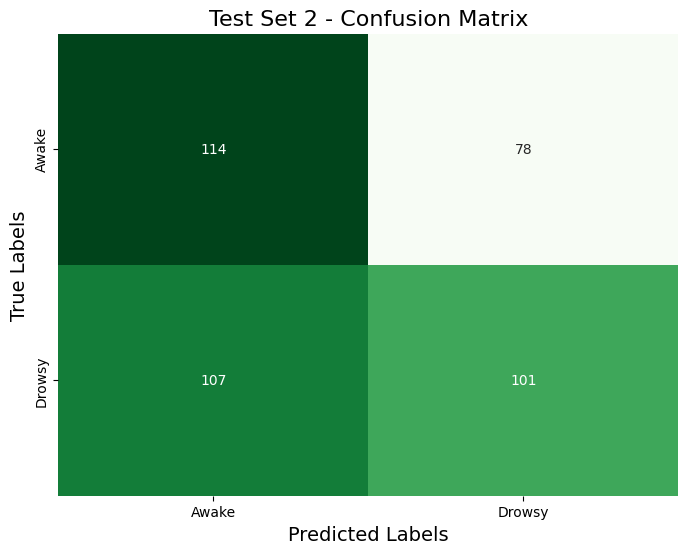

Test Set 2 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.52      0.59      0.55       192
      Drowsy       0.56      0.49      0.52       208

    accuracy                           0.54       400
   macro avg       0.54      0.54      0.54       400
weighted avg       0.54      0.54      0.54       400



In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()

def evaluate_model(model, data_generator, class_names, dataset_name):
    y_pred = model.predict(data_generator)
    y_pred = (y_pred > 0.5).astype(int).flatten()
    y_true = np.concatenate([data_generator[i][1] for i in range(len(data_generator))])
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{dataset_name} - Accuracy: {accuracy:.4f}\n")
    print(f"{dataset_name} - Confusion Matrix:")
    plot_confusion_matrix(y_true, y_pred, class_names, title=f"{dataset_name} - Confusion Matrix")
    print(f"{dataset_name} - Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print(report)

print("Evaluation on Test Set 1:")
evaluate_model(mobilenet_model, test_gen, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 1")

print("\nEvaluation on Test Set 2:")
evaluate_model(mobilenet_model, new_test_gen, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 2")


In [6]:

mobilenet_model.save("mobilenetExtraAugmentation.keras")
print("Model saved as 'mobilenetExtraAugmentation.keras'")


Model saved as 'mobilenetExtraAugmentation.keras'


### EfficientNetV2B0

In [7]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

base_model = EfficientNetV2B0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in base_model.layers[:200]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3), name='image_input')
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

efficientnet = Model(inputs, output)

efficientnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

historyEfficientNet = efficientnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stopping],
    batch_size=32
)



Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 149s 671ms/step - accuracy: 0.5111 - loss: 2.0063 - val_accuracy: 0.5042 - val_loss: 0.8098
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 111s 579ms/step - accuracy: 0.5014 - loss: 0.7750 - val_accuracy: 0.5042 - val_loss: 0.7047
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 109s 569ms/step - accuracy: 0.5213 - loss: 0.7020 - val_accuracy: 0.4958 - val_loss: 0.7050
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 105s 549ms/step - accuracy: 0.4736 - loss: 0.7091 - val_accuracy: 0.4958 - val_loss: 0.7012
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 108s 565ms/step - accuracy: 0.5090 - loss: 0.7001 - val_accuracy: 0.4958 - val_loss: 0.6941
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 107s 557ms/step - accuracy: 0.5101 - loss: 0.6940 - val_accuracy: 0.4958 - val_loss: 0.6937
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 106s 552ms/step - accuracy: 0.5013 - loss: 0.6936 - val_accuracy: 0.4958 - val_loss: 0.6937
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 105s 550ms/step - accuracy: 0.5043 -

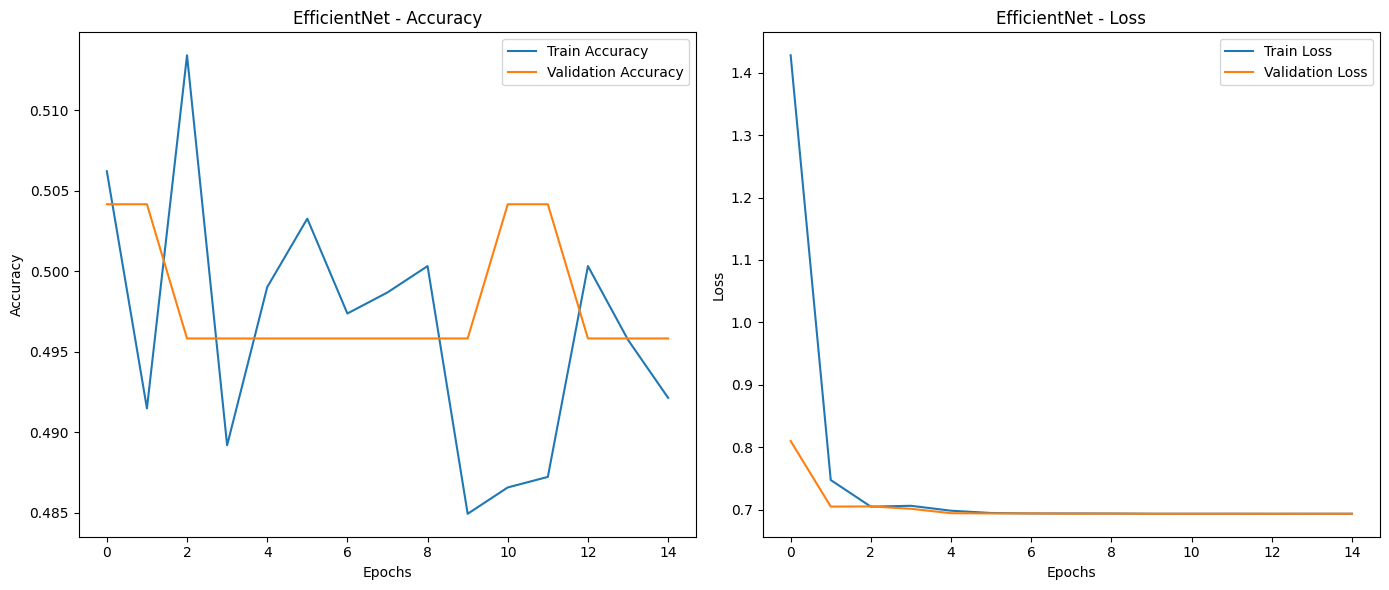

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(historyEfficientNet.history['accuracy'], label='Train Accuracy')
plt.plot(historyEfficientNet.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNet - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historyEfficientNet.history['loss'], label='Train Loss')
plt.plot(historyEfficientNet.history['val_loss'], label='Validation Loss')
plt.title('EfficientNet - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:

final_training_accuracy = historyEfficientNet.history['accuracy'][-1]
final_validation_accuracy = historyEfficientNet.history['val_accuracy'][-1]
final_training_loss = historyEfficientNet.history['loss'][-1]
final_validation_loss = historyEfficientNet.history['val_loss'][-1]


print("Final Training Accuracy: {:.4f}".format(final_training_accuracy))
print("Final Validation Accuracy: {:.4f}".format(final_validation_accuracy))
print("Final Training Loss: {:.4f}".format(final_training_loss))
print("Final Validation Loss: {:.4f}".format(final_validation_loss))

Final Training Accuracy: 0.4921
Final Validation Accuracy: 0.4958
Final Training Loss: 0.6932
Final Validation Loss: 0.6932


Evaluation on Test Set 1:
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step
Test Set 1 - Accuracy: 0.5813

Test Set 1 - Confusion Matrix:


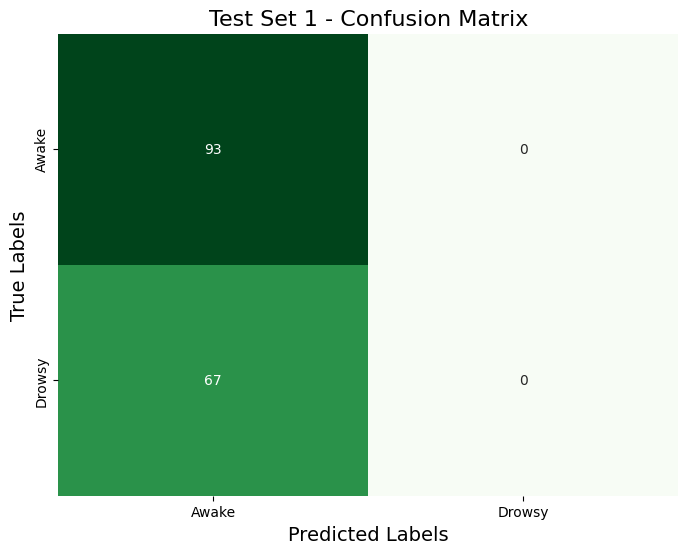

Test Set 1 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.58      1.00      0.74        93
      Drowsy       0.00      0.00      0.00        67

    accuracy                           0.58       160
   macro avg       0.29      0.50      0.37       160
weighted avg       0.34      0.58      0.43       160


Evaluation on Test Set 2:
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 320ms/step
Test Set 2 - Accuracy: 0.4800

Test Set 2 - Confusion Matrix:


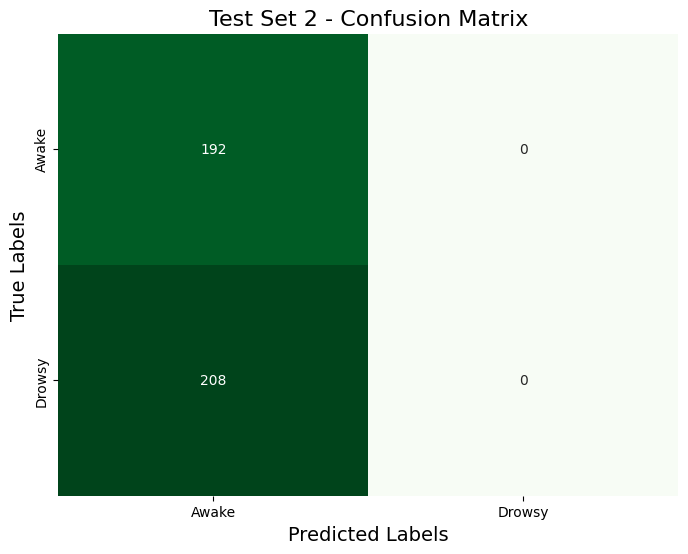

Test Set 2 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.48      1.00      0.65       192
      Drowsy       0.00      0.00      0.00       208

    accuracy                           0.48       400
   macro avg       0.24      0.50      0.32       400
weighted avg       0.23      0.48      0.31       400



In [9]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()

def evaluate_model(model, data_generator, class_names, dataset_name):
    y_pred = model.predict(data_generator)
    y_pred = (y_pred > 0.5).astype(int).flatten()
    y_true = np.concatenate([data_generator[i][1] for i in range(len(data_generator))])
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{dataset_name} - Accuracy: {accuracy:.4f}\n")
    print(f"{dataset_name} - Confusion Matrix:")
    plot_confusion_matrix(y_true, y_pred, class_names, title=f"{dataset_name} - Confusion Matrix")
    print(f"{dataset_name} - Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print(report)

print("Evaluation on Test Set 1:")
evaluate_model(efficientnet, test_gen, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 1")

print("\nEvaluation on Test Set 2:")
evaluate_model(efficientnet, new_test_gen, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 2")


In [10]:

efficientnet.save("efficientnetExtraAugmentation.keras")
print("Model saved as 'efficientnetExtraAugmentation.keras'")


Model saved as 'efficientnetExtraAugmentation.keras'


### ResNet50

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in base_model.layers[:140]:
    layer.trainable = False

input_layer = Input(shape=(224, 224, 3), name='input')
x = base_model(input_layer)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

resnet = Model(inputs=input_layer, outputs=output)

resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

historyResnet = resnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stopping],
    batch_size=32
)


Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.5058 - loss: 1.8759 - val_accuracy: 0.4958 - val_loss: 0.7620
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.5210 - loss: 0.7329 - val_accuracy: 0.4958 - val_loss: 0.6981
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.4875 - loss: 0.6962 - val_accuracy: 0.5375 - val_loss: 0.6938
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.5104 - loss: 0.6938 - val_accuracy: 0.4958 - val_loss: 0.6934
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.5055 - loss: 0.6933 - val_accuracy: 0.4958 - val_loss: 0.6933
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.5011 - loss: 0.6934 - val_accuracy: 0.4958 - val_loss: 0.6933
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.4988 - loss: 0.6933 - val_accuracy: 0.5042 - val_loss: 0.6931
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.5171 - loss: 0.6934 - val_accu

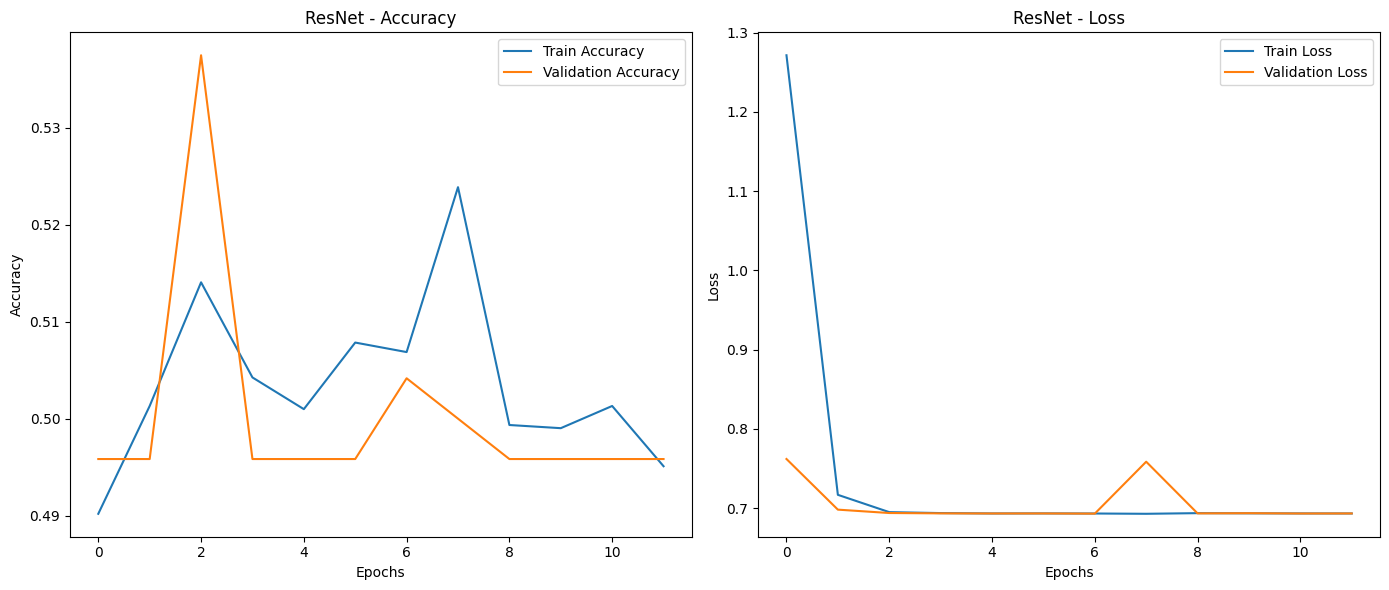

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(historyResnet.history['accuracy'], label='Train Accuracy')
plt.plot(historyResnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historyResnet.history['loss'], label='Train Loss')
plt.plot(historyResnet.history['val_loss'], label='Validation Loss')
plt.title('ResNet - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:

final_training_accuracy = historyResnet.history['accuracy'][-1]
final_validation_accuracy = historyResnet.history['val_accuracy'][-1]
final_training_loss = historyResnet.history['loss'][-1]
final_validation_loss = historyResnet.history['val_loss'][-1]


print("Final Training Accuracy: {:.4f}".format(final_training_accuracy))
print("Final Validation Accuracy: {:.4f}".format(final_validation_accuracy))
print("Final Training Loss: {:.4f}".format(final_training_loss))
print("Final Validation Loss: {:.4f}".format(final_validation_loss))


Final Training Accuracy: 0.4951
Final Validation Accuracy: 0.4958
Final Training Loss: 0.6933
Final Validation Loss: 0.6933


Evaluation on Test Set 1:
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 908ms/step
Test Set 1 - Accuracy: 0.5813

Test Set 1 - Confusion Matrix:


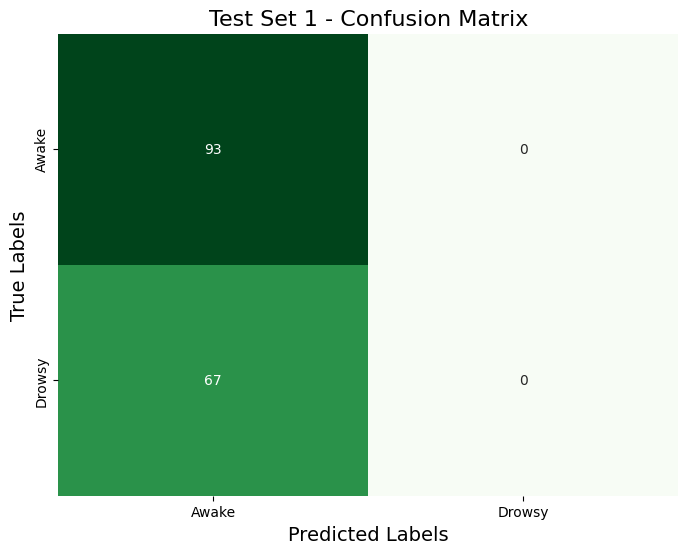

Test Set 1 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.58      1.00      0.74        93
      Drowsy       0.00      0.00      0.00        67

    accuracy                           0.58       160
   macro avg       0.29      0.50      0.37       160
weighted avg       0.34      0.58      0.43       160


Evaluation on Test Set 2:
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 945ms/step
Test Set 2 - Accuracy: 0.4875

Test Set 2 - Confusion Matrix:


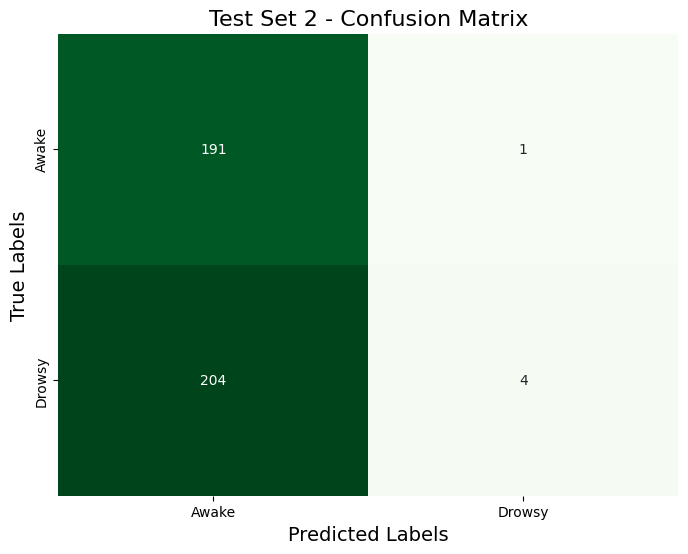

Test Set 2 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.48      0.99      0.65       192
      Drowsy       0.80      0.02      0.04       208

    accuracy                           0.49       400
   macro avg       0.64      0.51      0.34       400
weighted avg       0.65      0.49      0.33       400



In [14]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()

def evaluate_model(model, data_generator, class_names, dataset_name):
    y_pred = model.predict(data_generator)
    y_pred = (y_pred > 0.5).astype(int).flatten()
    y_true = np.concatenate([data_generator[i][1] for i in range(len(data_generator))])
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{dataset_name} - Accuracy: {accuracy:.4f}\n")
    print(f"{dataset_name} - Confusion Matrix:")
    plot_confusion_matrix(y_true, y_pred, class_names, title=f"{dataset_name} - Confusion Matrix")
    print(f"{dataset_name} - Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print(report)

print("Evaluation on Test Set 1:")
evaluate_model(resnet, test_gen, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 1")

print("\nEvaluation on Test Set 2:")
evaluate_model(resnet, new_test_gen, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 2")


In [15]:

resnet.save("resnetExtraAugmentation.keras")
print("Model saved as 'resnetExtraAugmentation.keras'")


Model saved as 'resnetExtraAugmentation.keras'
